In [1]:
chan_index = int(input('Enter channel index to analyze:'))
# print('Enter Open Ephys data directory path:')
# source_path = raw_input()

Enter channel index to analyze:1


In [2]:
source_path = '../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/'

In [3]:
import time
t0 = time.time()
import OpenEphys
from kaveh.toolbox import common_avg_ref, butter_bandpass_filter
import Kwik
from matplotlib import pyplot as plt
import numpy as np
import os
import re
import scipy.signal

In [4]:
%matplotlib notebook
%load_ext autoreload
%autoreload 2

In [5]:
f_names = []
for root, dirnames, filenames in os.walk(source_path):
    for filename in filenames:
        f_regex = re.compile(r".*CH(\d|\d\d)\.continuous$")
        if f_regex.match(filename):
            f_names = f_names + [os.path.join(root, filename)]
f_names = np.array(f_names)
chans = [int(f.split('.')[-2].split('_')[-1][2:]) for f in f_names]
f_names = f_names[np.argsort(chans)] # now sorted by channel number

In [6]:
chan_data = []
for contact in range(4):
    contact_reps = []
    for i in range(contact*4, contact*4 + 4):
        print('Reading {}...'.format(f_names[i]))
        file_content = OpenEphys.load(f_names[i])
        Fs = float(file_content['header']['sampleRate'])
        signal_filtered = butter_bandpass_filter(file_content['data'], 200, 10000, Fs, order=2 )
        contact_reps.append(signal_filtered)
    contact_reps = np.array(contact_reps)
    chan_data.append(np.mean(contact_reps, axis=0))
    print('-----------------------------------------------')
chan_data = np.array(chan_data)
contact_reps = None

Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH1.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH2.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH3.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH4.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH5.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH6.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH7.continuous...
Loading continuous data...
Reading ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/100_CH8.continuous...
Loading continuous data...
-----------------------------------------------
Reading ../data/

In [7]:
common_avg_ref(chan_data)
chan_data = scipy.signal.detrend(chan_data)

chan_filtered_fname = os.path.join(source_path, 'channels_filtered_200-3kHz.npy')
print('Saving filtered data to {}'.format(chan_filtered_fname))
np.save(chan_filtered_fname, chan_data)

Saving filtered data to ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channels_filtered_200-3kHz.npy


In [23]:
chan_filtered_fname = os.path.join(source_path, 'channels_filtered_200-10kHz.npy')
chan_data = np.load(chan_filtered_fname)
Fs = 30000.0

### Plot channel voltage

In [46]:
from cssorter.spikesorter import ComplexSpikeSorter
dt = 1.0/Fs
css = ComplexSpikeSorter(chan_data[chan_index, :], dt)
css.num_gmm_components = 3
css.cs_num_gmm_components = 4
css.pre_window = 0.0002
css.post_window = 0.004
css.run(use_filtered=True, remove_overlap=False, spike_detection_dir = 'max', align_spikes_to='min')

Pre-process...
Using minibatch spike detection, batch size = 50s, using filter (derivative) is True
Using spikes max for detection. Aligning them to their min. 
Spike detection time = 46.720394134521484
Using all spikes for alignment (no overlap removal)
Align spikes time = 0.36063051223754883
Clustering complex spikes...
Splitting detected spikes for CS clustering ...
CS spike detection time = 50.527246713638306
Merging overlapping CS waveforms
CS post process time = 0.017933368682861328


<IPython.core.display.Javascript object>


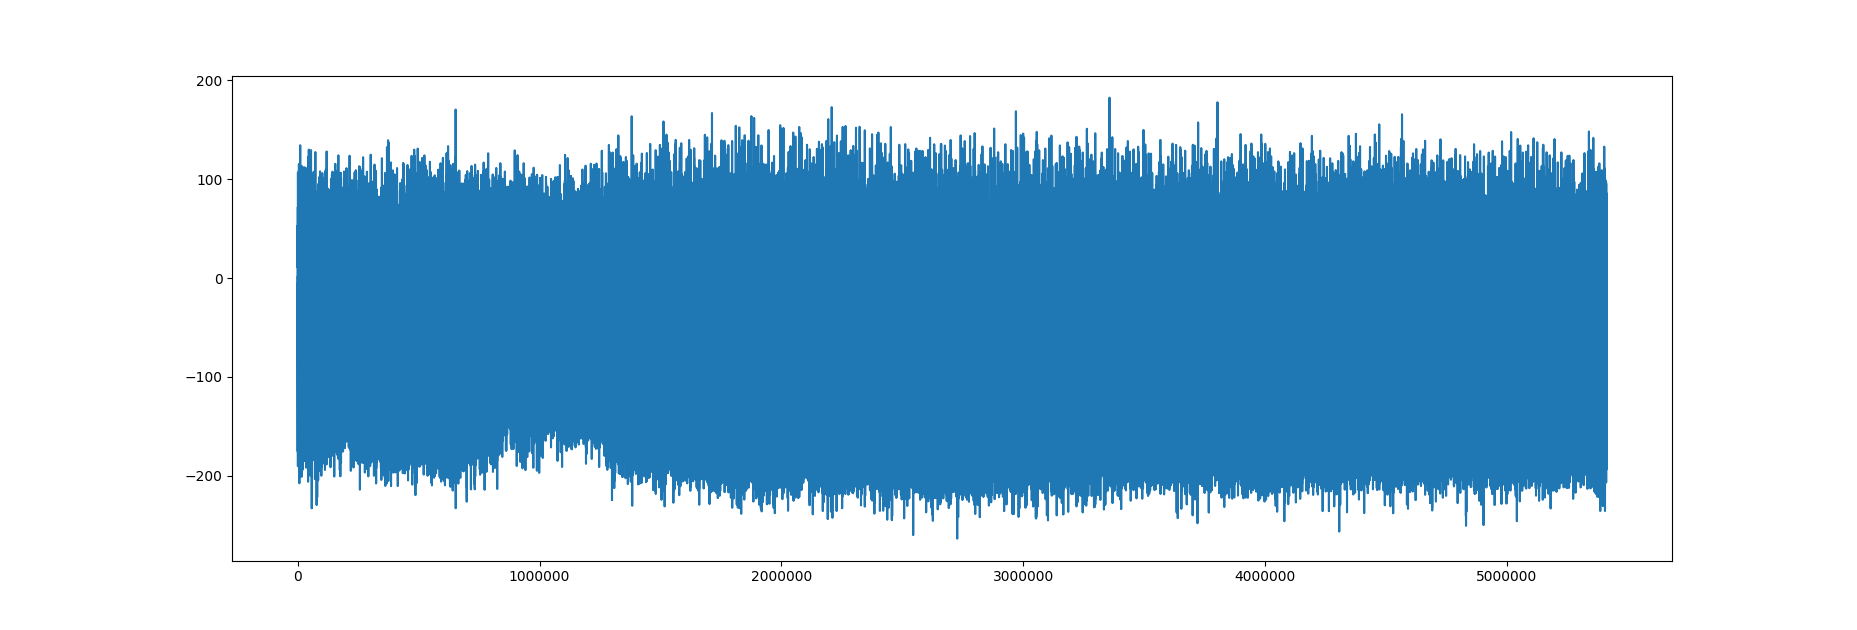

In [20]:
plt.figure()
plt.plot(chan_data[chan_index, ::10])

In [47]:
css.cs_indices.shape

(6157,)

In [52]:
ss_indices = css.get_ss_indices()

In [51]:
powers = [] 
max_powers = []
phases = []
for wf in css.aligned_spikes:
# wf = css.aligned_spikes[10]
    yf = scipy.fftpack.fft(wf)
    N = wf.size
    xf = np.linspace(0.0, 1.0 / (2.0 * css.dt), N/2)
    mask = (xf < css.freq_range[1]) & (xf >= css.freq_range[0])
    power_spectrum = 2.0/N * np.abs(yf[:N//2])
    phase_spectrum =  np.angle(yf[:N//2])
    max_powers = max_powers + [np.max(power_spectrum[mask])]
    powers.append(power_spectrum)
    phases.append(phase_spectrum)
max_powers = np.asarray(max_powers)
powers = np.array(powers)
phases = np.array(phases)
# return max_powers, powers, xf[mask] 


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.
  


In [68]:
cs_power_ids = np.where(np.isin(css.get_spike_indices(remove_overlaps=False), css.cs_indices))[0]
ss_power_ids = np.where( np.logical_not(np.isin(css.get_spike_indices(), css.cs_indices)))[0]

In [23]:
css.cs_indices.shape

(7732,)

In [69]:
cs_power_ids.shape

(1974,)

In [70]:
mean_powers_cs = np.mean(phases[cs_power_ids,:], axis = 0)
se_powers_cs = np.std(phases[cs_power_ids,:], axis = 0)

mean_powers_ss = np.mean(phases[ss_power_ids,:], axis = 0)
se_powers_ss = np.std(phases[ss_power_ids,:], axis = 0)

<IPython.core.display.Javascript object>


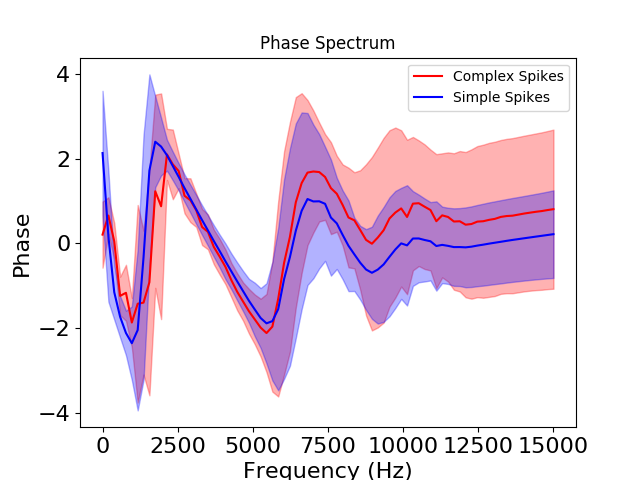

Text(0.5, 1.0, 'Phase Spectrum')

In [72]:
plt.figure()
plt.plot(xf, mean_powers_cs, 'r')
plt.fill_between(xf, mean_powers_cs - se_powers_cs, mean_powers_cs + se_powers_cs, alpha = 0.3, color = 'r')
plt.plot(xf, mean_powers_ss, 'b')
plt.fill_between(xf, mean_powers_ss - se_powers_ss, mean_powers_ss + se_powers_ss, alpha = 0.3, color = 'b')

plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)

plt.ylabel('Phase', fontsize=16)
plt.xlabel('Frequency (Hz)', fontsize=16)
plt.legend(['Complex Spikes', 'Simple Spikes'])
plt.title('Phase Spectrum')

<IPython.core.display.Javascript object>


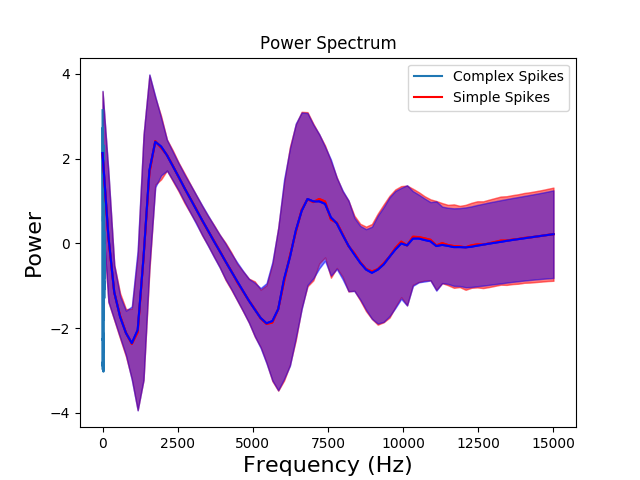

In [48]:
plt.figure()
plt.plot(phase_spectrum)
# plt.plot(power_spectrum)

In [34]:
yf[7].imag

-1038899.470498078

In [37]:
print(cm.phase(yf[2]))
print(np.arctan2(yf[2].imag, yf[2].real))
print(-np.angle(yf[2]))


-1.0407067827910907
-1.0407067827910907
1.0407067827910907


<IPython.core.display.Javascript object>


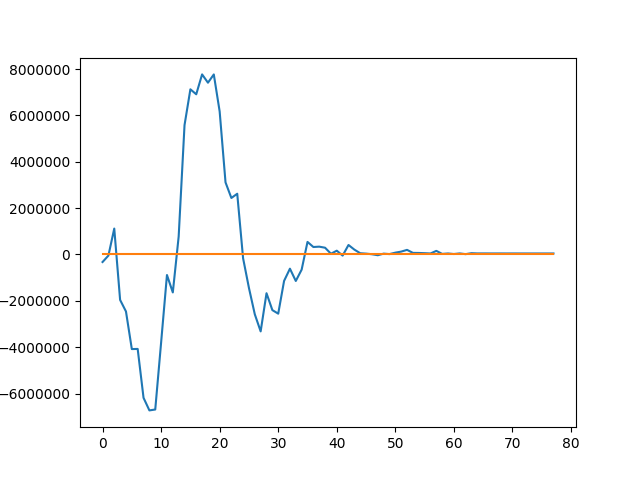

In [18]:
plt.figure()
plt.plot(yf[:N//2])

In [73]:
num_clusters = 12
pre_time = 0.0005
post_time = 0.0035
clusters, cluster_labels = css.cluster_detected_cs(num_clusters=num_clusters, pre_time=pre_time, post_time=post_time, align_to='min')
ss_indices = css.get_ss_indices()

In [74]:
ss_indices.shape

(136386,)

In [75]:
import random
pre_index = int(np.round(pre_time/css.dt))
post_index = int(np.round(post_time/css.dt))
aligned_ss = np.array([css.voltage[i - pre_index : i + post_index] for i in ss_indices[1:-2]])
mean_ss = np.mean(aligned_ss[random.sample(range(0, aligned_ss.shape[0]), css.cs_indices.size), ], axis=0)

In [76]:
t1 = time.time()
print('Total run time = {} s'.format(t1-t0))

Total run time = 2746.94939160347 s


<IPython.core.display.Javascript object>


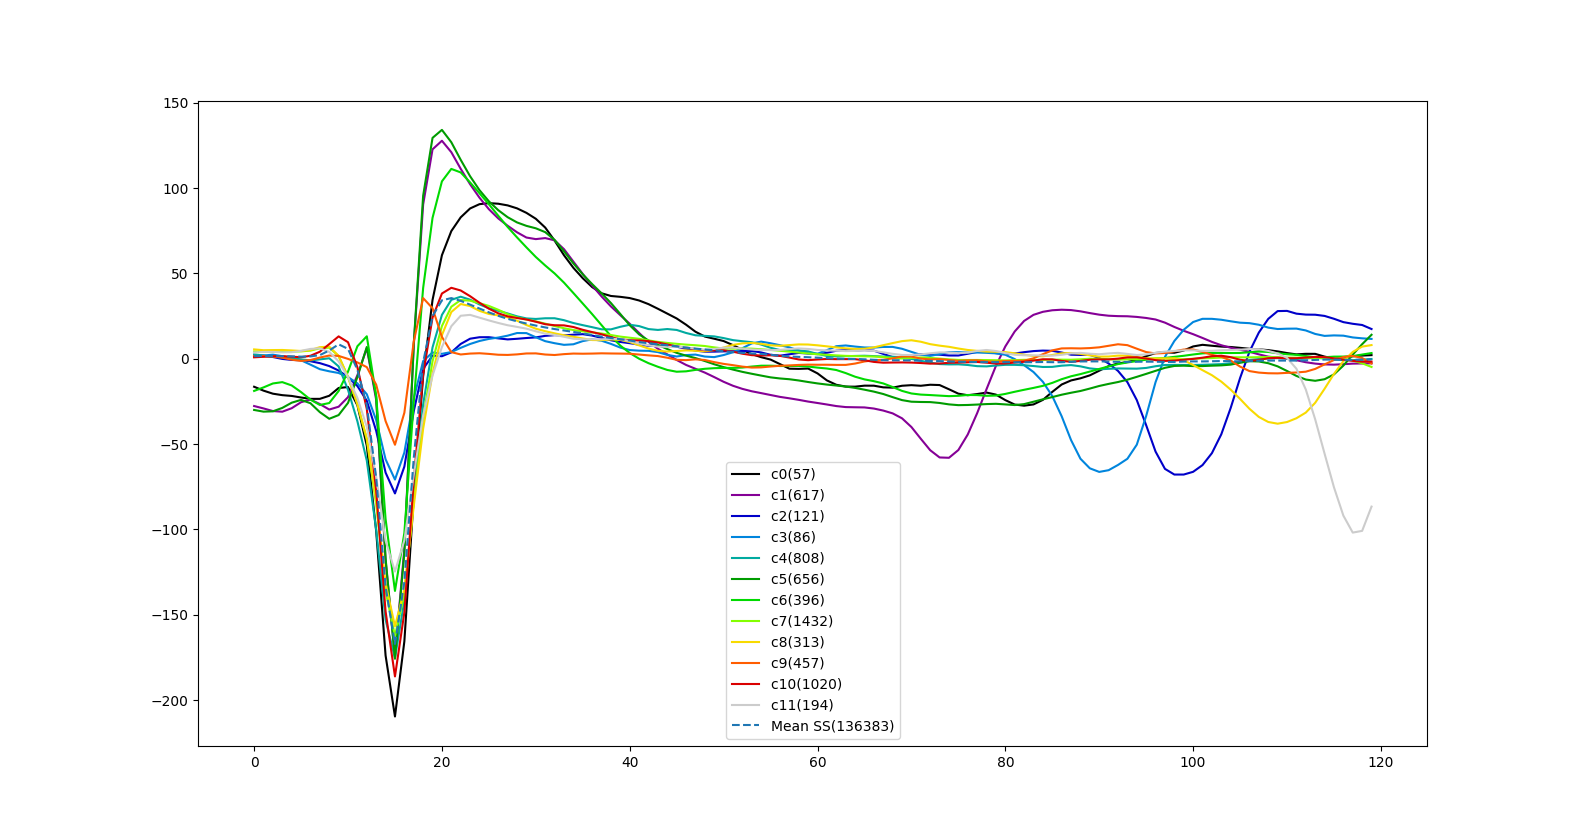

In [77]:
# plot cluster means
colors = plt.cm.nipy_spectral(np.linspace(0,1,num_clusters))
legend_labels = []
for cn in np.arange(num_clusters):
    legend_labels.append('c{}({}) '.format(cn, clusters[cn].shape[0]))

import gc
gc.collect()
plt.figure(figsize=(8,5))
clust_means = []
paxes = []
for cn in np.arange(num_clusters):
    clust_means.append(np.mean(clusters[cn], axis=0))
    ax = plt.plot(clust_means[-1], color = colors[cn], label = legend_labels[cn])
    paxes.append(ax)
plt.plot(mean_ss, '--', label = 'Mean SS({})'.format(aligned_ss.shape[0]))
plt.legend() 

In [83]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2, random_state=0).fit(clust_means)
cs_clust = np.argmax(np.sum(np.abs(kmeans.cluster_centers_), axis=1))
clusters_to_pick = np.where(kmeans.labels_ == cs_clust)[0]
print('Detected CS clusters: {}'.format(clusters_to_pick))

Detected CS clusters: [0 1 5 6]


In [80]:
ans = input("Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: ")
ans_regex = re.compile(r'\d+(?:,\d+)?')
if ans_regex.match(ans):
    clusters_to_pick = [int(c) for c in ans.split(',')]
    

Enter CS clusters (comma separated; example: 5,3,1). Type a character to accept the detected cluster: 0


In [84]:
cs_indices_to_pick = []
for cti in clusters_to_pick:
    cs_indices_to_pick = np.union1d(cs_indices_to_pick, css.cs_indices[np.where(cluster_labels == cti)])
cs_indices = cs_indices_to_pick.astype(np.int64)
print('Number of detected CS: {}'.format(cs_indices.shape))

Number of detected CS: (1726,)


In [63]:
ss_indices = np.setdiff1d(css.spike_indices, cs_indices)

<IPython.core.display.Javascript object>


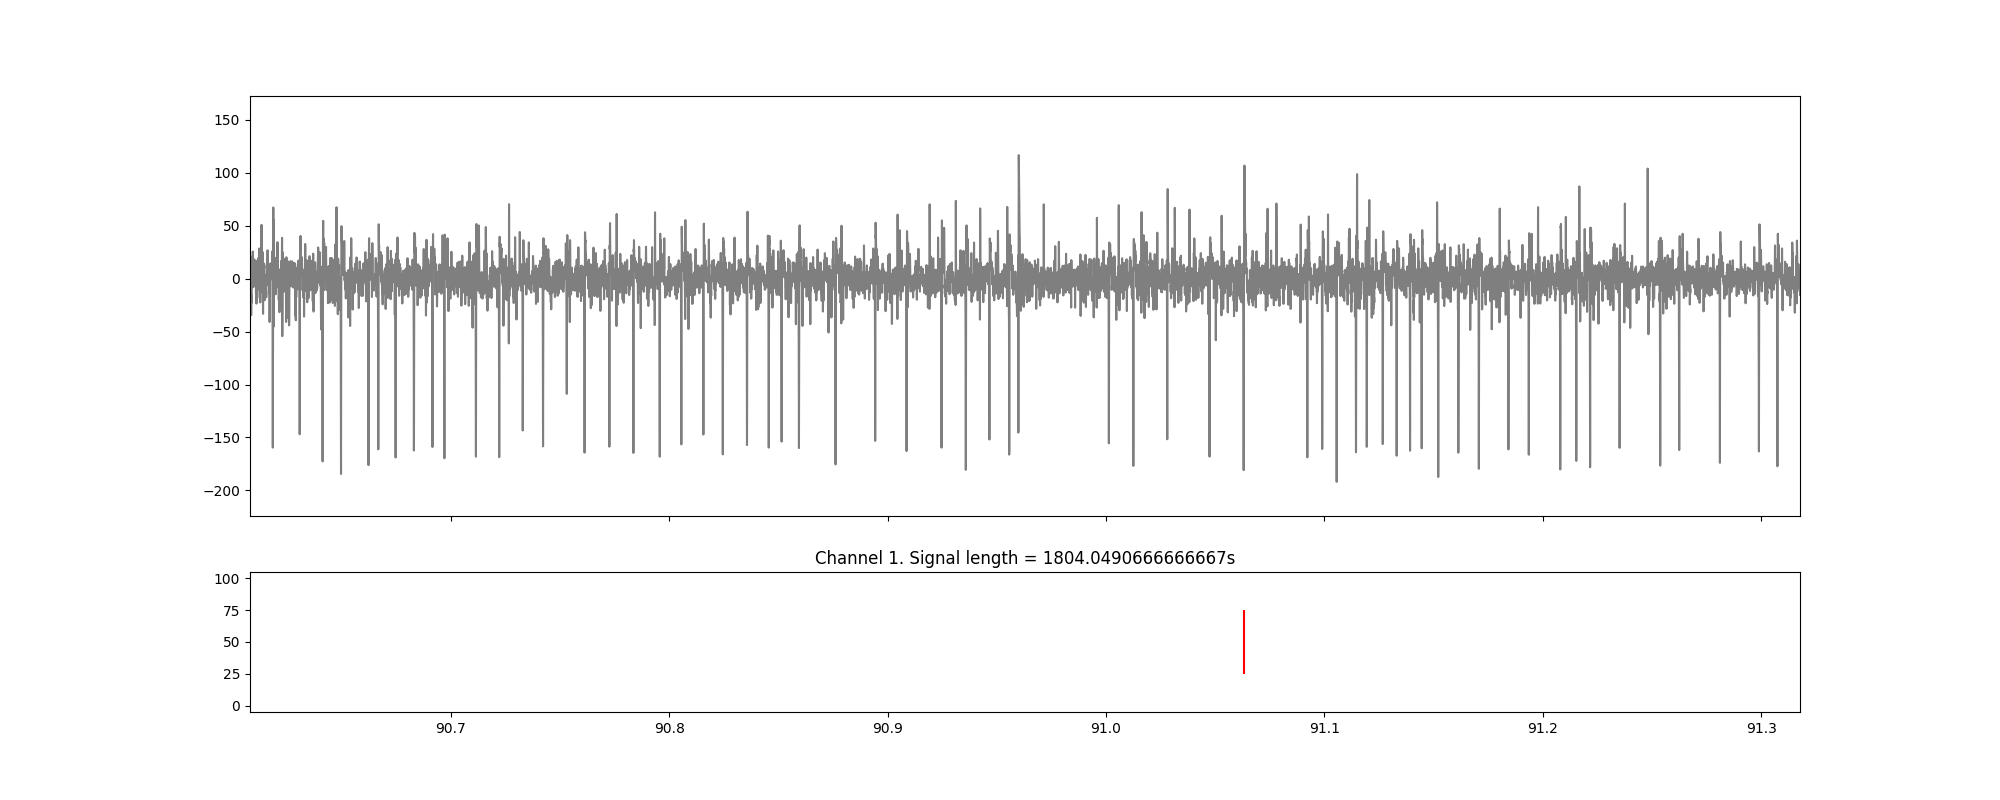

Text(0.5, 1.0, 'Channel 1. Signal length = 1804.0490666666667s')

In [82]:
# plot channel
f, (ax0, ax1) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, figsize=(20,8), sharex=True)

# prange = [css.signal_size*css.dt - 100, css.signal_size*css.dt] #s
prange = [20,120] #s
idx_voltage = [int(pr*Fs) for pr in prange]
ax0.plot(np.arange(prange[0],prange[1],1/Fs), chan_data[chan_index, idx_voltage[0]: idx_voltage[1]], alpha=0.5, color='k')
# ax1.eventplot(css.cs_indices[np.where(np.logical_and(css.cs_indices < idx_voltage[1] , css.cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=0, color='g')
ax1.eventplot(cs_indices[np.where(np.logical_and(cs_indices < idx_voltage[1] , cs_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=50, color='r')
# ax1.eventplot(css.spike_indices[np.where(np.logical_and(css.spike_indices < idx_voltage[1] , css.spike_indices >= idx_voltage[0]))]*css.dt, linelengths=50, lineoffsets=100, color='m')
# plt.plot(chan_data[chan_index,::10])
plt.title('Channel {}. Signal length = {}s'.format(chan_index, chan_data.shape[1]/Fs))

In [39]:
pv = chan_data[chan_index, idx_voltage[0]: idx_voltage[1]]


In [43]:
signal_filtered = butter_bandpass_filter(pv, 200, 5000, Fs, order=2 )

<IPython.core.display.Javascript object>


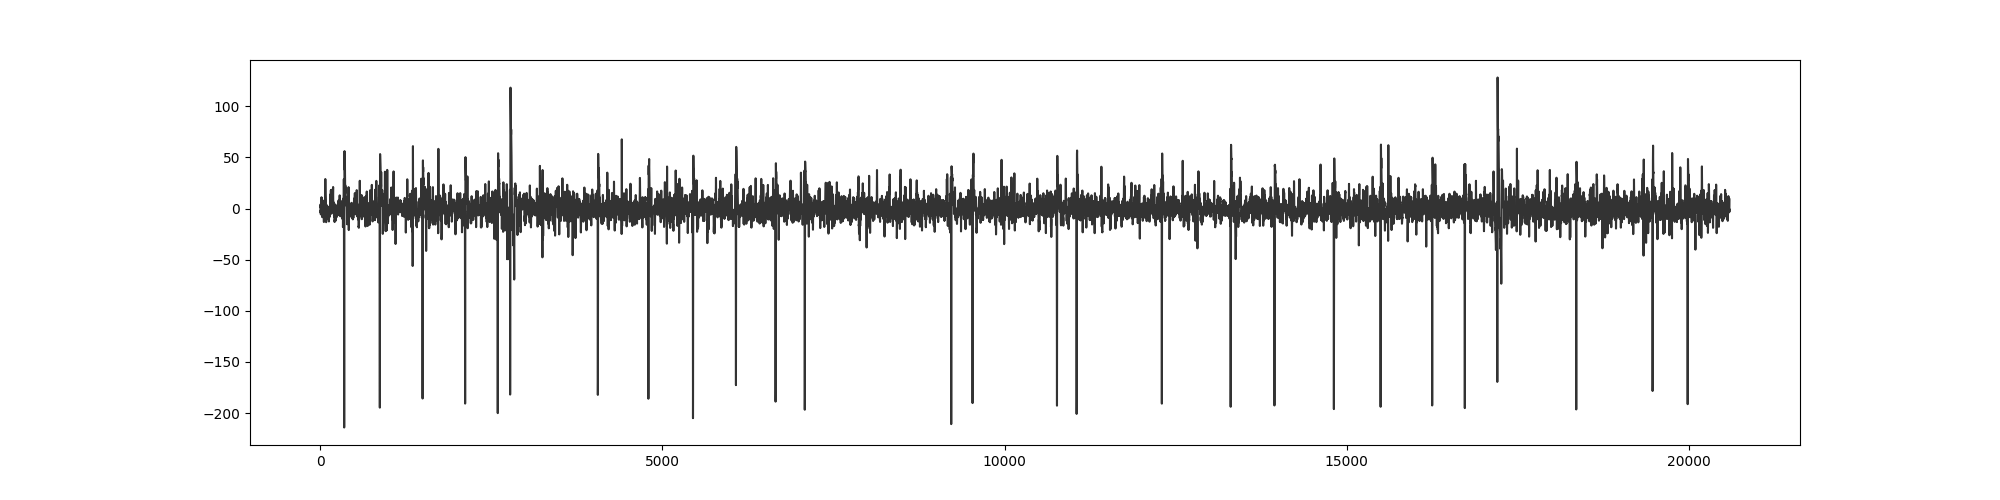

In [52]:
import scipy.signal

filtered = scipy.signal.savgol_filter(pv, 9, 2, 0, 1/Fs)
plt.figure(figsize=(20,5))
# plt.plot(signal_filtered, alpha = 0.3 , color='k')
# plt.plot(filtered, alpha=0.3, color='r')
plt.plot(pv[4900:25500], alpha=0.8, color='k')
# plt.plot(pv)



In [54]:
plt.savefig('../data/pcell-for-laserprint.svg')

<IPython.core.display.Javascript object>


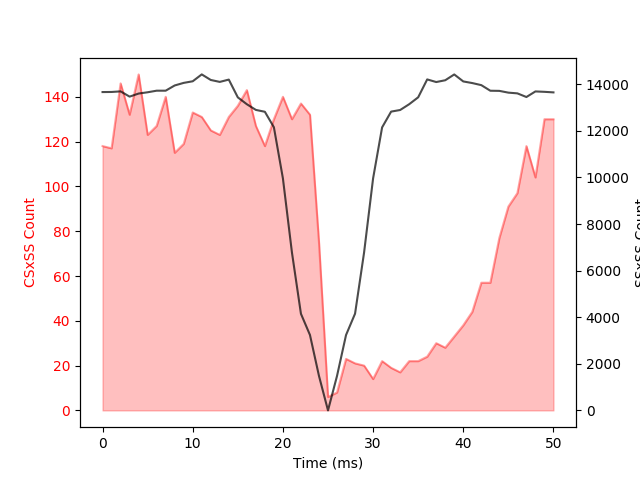

Text(0, 0.5, 'SSxSS Count')

In [85]:
SS = np.zeros(np.int64(css.signal_size/30.0))
SS[np.int64(ss_indices/30.0)] = 1
CS = np.zeros(np.int64(css.signal_size/30.0))
CS[np.int64(cs_indices/30.0)] = 1


window = 25
xcor_vect = np.zeros((2*window + 1))
for cti in np.int64(cs_indices[:-1]/30.0):
    xcor_vect = xcor_vect + SS[cti-window : cti + window + 1]

window = 25
acor_vect = np.zeros((2*window + 1))
for sti in np.int64(ss_indices[10:-10]/30.0):
    acor_vect = acor_vect + SS[sti-window : sti + window + 1]

acor_vect[25] = 0

plt.figure()
plt.plot(xcor_vect, 'r', alpha=0.35)
plt.yticks(color='r')
plt.fill_between(np.arange(0,2*window + 1), xcor_vect, color='r', alpha=0.25)
plt.ylabel('CSxSS Count', color = 'r')
plt.xlabel('Time (ms)')

plt.twinx()
plt.plot(acor_vect, 'k', alpha=0.70)
plt.yticks(color='k')
plt.ylabel('SSxSS Count', color='k')
# plt.fill_between(acor_ret[0], 0, acor_ret[1] , color='g', alpha=0.25)


<IPython.core.display.Javascript object>


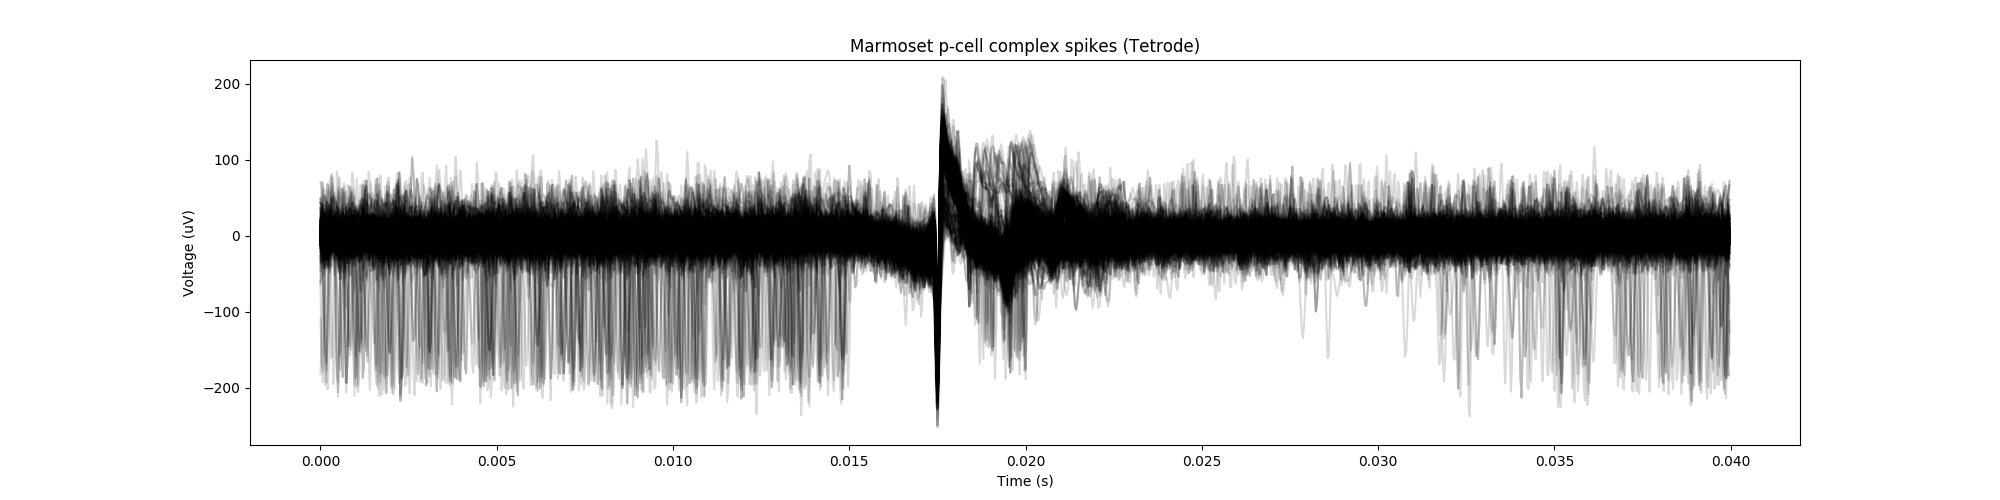

Text(0.5, 1.0, 'Marmoset p-cell complex spikes (Tetrode)')

In [86]:
pre_index = int(0.020*Fs)
post_index = int(0.020*Fs)
aligned_cs = []
aligned_cs_indices = []
rand_ind = np.random.randint(0,cs_indices.size, 500)
for i in cs_indices[rand_ind]:
    cs_idx = np.argmin(css.voltage[i - int(0.0025*Fs) : i + int(0.002*Fs)])+i
    aligned_cs_indices.append(cs_idx)
    aligned_cs.append(css.voltage[cs_idx - pre_index : cs_idx + post_index])

aligned_cs = np.array(aligned_cs)
aligned_cs_indices = np.array(aligned_cs_indices)
plt.figure(figsize=(20,5))
# csi = cs_indices[7]
# print(csi*dt)
for acs in aligned_cs:
    plt.plot(np.arange(0,acs.size*dt, dt), acs, color='k', alpha=0.15)
plt.xlabel('Time (s)')
plt.ylabel('Voltage (uV)')
plt.title('Marmoset p-cell complex spikes (Tetrode)')

## Saving detected CS and SS:

In [87]:
CS_csv_filename = os.path.join(source_path, 'channel_{}.CS.csv'.format(chan_index))
SS_csv_filename = os.path.join(source_path, 'channel_{}.SS.csv'.format(chan_index))

import csv
with open(CS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(CS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(cs_indices.reshape(-1,1))
    
with open(SS_csv_filename, 'w+') as f:
    print('writing {} ... '.format(SS_csv_filename))
    f.seek(0)
    csvwriter = csv.writer(f, delimiter = ',')
    csvwriter.writerows(ss_indices.reshape(-1,1))

writing ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.CS.csv ... 
writing ../data/OpenEphys_data/2019-08-12/2019-08-12_15-33-54/channel_1.SS.csv ... 


In [ ]:
plt.figure(figsize=(20,5))
plt.plot(chan_data_raw[chan_index,:], alpha = 0.5)
plt.plot(chan_data[chan_index,:], alpha = 0.8)
plt.eventplot(cs_indices, linelengths=300, colors='r', alpha=0.4)
